# Content
Il s'agit du notebook final de notre projet qui contient le pipeline de modélisation :
- Installation de notre librairie et mise à jour des dépendances
- Chargement des données d'imagerie médicale
- Préparation des jeux de données : entrainement, validation et test
- Modélisation d'un réseau de convolution
    - Apprentissage par transfer learning
    - Optimisation par fine tuning
- Prédiction sur un jeu d'images de test


# 1. Préparation de l'environnement

**N'oubliez pas de redémarrer le runtime après l'exécution de la cellule suivante et de bien vérifier que vous avez accès à un GPU.**

In [1]:
!pip -q install git+https://github.com/corralien/yawbcc.git

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print(f'Tensorflow: {tf.__version__}')
gpu_count = sum(1 for dev in tf.config.experimental.list_physical_devices()
                    if dev.device_type == 'GPU')
print(f'Number of GPUs: {gpu_count}')

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow: 2.10.0
Number of GPUs: 0


# 2. Chargement des données

>Nous téléchargeons les images à partir d'une archive zip. Nous avons à disposition 2 jeux de données :
>- barcelona : le jeu de données original des images médicales,
>- barcelona_256_masked : un jeu de données restreint issu d'un processus de segmentation.

In [2]:
import urllib.request
import pathlib
import shutil

DATASETS = {
    'barcelona': 'https://cloud.minesparis.psl.eu/index.php/s/r9oFCMOTI5zVcd9/download',
    'barcelona_remapped': 'https://cloud.minesparis.psl.eu/index.php/s/MmAkMdd9wrmcgUq/download',
    'barcelona_256_masked': 'https://cloud.minesparis.psl.eu/index.php/s/S5mPzVRXmwXUiYc/download',
}

# Change HERE
dataset = 'barcelona'  # or barcelona for full dataset

# Define some folder
BASE_DIR = pathlib.Path.home() / 'yawbcc_data'
BASE_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = BASE_DIR / dataset

print(f'Base directory {BASE_DIR}')
print(f'Data directory {DATA_DIR}')

arch, _ = urllib.request.urlretrieve(DATASETS[dataset])
shutil.unpack_archive(arch, BASE_DIR, 'zip')

Base directory /Users/Anastasiya/yawbcc_data
Data directory /Users/Anastasiya/yawbcc_data/barcelona


>Puis nous créons 3 jeux de données : train, valid et test :

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Find images of dataset
data = []
for file in DATA_DIR.glob('**/*.jpg'):
    d = {'image': file.name,
         'group': file.parent.name.upper(),
         'label': file.stem.split('_')[0].upper(),
         'path': str(file)}
    data.append(d)

# Create dataframe and select columns
df = pd.DataFrame(data)
X = df['path']
y, cats = pd.factorize(df['group'])

# For converting numeric class to label
num_to_label = dict(enumerate(cats))

# Split into 3 balanced datasets 
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y, random_state=2022)
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=2022)

# Remember each dataset
df.loc[X_train.index, 'dataset'] = 'train'
df.loc[X_test.index, 'dataset'] = 'test'
df.loc[X_valid.index, 'dataset'] = 'valid'

print(f'Train: {len(X_train)} records')
print(f'Valid: {len(X_valid)} records')
print(f'Test: {len(X_test)} records')

df.groupby('group').sample(n=1, random_state=2022).sort_index()

Train: 10938 records
Valid: 2735 records
Test: 3419 records


,image,group,label,path,dataset
597,BA_773081.jpg,BASOPHIL,BA,/Users/Anastasiya/yawbcc_data/barcelona/basoph...,train
4225,BNE_785852.jpg,NEUTROPHIL,BNE,/Users/Anastasiya/yawbcc_data/barcelona/neutro...,train
6680,PMY_764313.jpg,IG,PMY,/Users/Anastasiya/yawbcc_data/barcelona/ig/PMY...,test
8420,MO_153378.jpg,MONOCYTE,MO,/Users/Anastasiya/yawbcc_data/barcelona/monocy...,valid
10780,EO_923869.jpg,EOSINOPHIL,EO,/Users/Anastasiya/yawbcc_data/barcelona/eosino...,train
12206,ERB_727394.jpg,ERYTHROBLAST,ERB,/Users/Anastasiya/yawbcc_data/barcelona/erythr...,valid
14709,LY_193962.jpg,LYMPHOCYTE,LY,/Users/Anastasiya/yawbcc_data/barcelona/lympho...,train
15392,PLATELET_21766.jpg,PLATELET,PLATELET,/Users/Anastasiya/yawbcc_data/barcelona/platel...,train


>A l'instar des générateurs, nous avons créé un chargeur de données qui hérite de la classe Sequence. Les images sont chargées et prétraitées à la demande par le modèle de convolution :

In [4]:
from yawbcc.datasets import WBCDataSequence

NUM_CLASSES = len(np.unique(y))
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32

train_ds = WBCDataSequence(X_train, y_train, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)
valid_ds = WBCDataSequence(X_valid, y_valid, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)
test_ds = WBCDataSequence(X_test, y_test, image_size=INPUT_SHAPE[:2], batch_size=BATCH_SIZE)

# 3. Modélisation d'un réseau de convolution
>Nous chargeons un modèle applicatif issu de la page Keras Applications comme départ de notre modélisation :
>- **MobileNetV2** par Anastasiya

## A. Transfer learning
>La première partie consiste à charger le modèle applicatif puis à l'intégrer dans notre modèle. Le modèle final sera composé ainsi :
>- Une couche d'entrée au format des images, par exemple (256, 256, 3),
>- Des couches de transformations (RandomFlip, RandomRotation, etc),
>- Le modèle fonctionnel applicatif (VGG16, ResNet50, MobileNet, etc),
>- Les couches de tête de réseau dont la dernière couche de classification.
>Afin de standardiser le processus de création de nos modèles, nous utilisons la fonction model_factory qui se charge d'assembler pour nous les différentes couches présentées ci-dessus.

In [5]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from yawbcc.models import model_factory

top_net = [
    Dropout(0.2, seed=2022, name='dropout'),
    Flatten('channels_last', name='flatten'),
    Dense(256, activation='relu', name='fc1'),
    Dense(256, activation='relu', name='fc2'),
    Dense(NUM_CLASSES, activation='softmax', name='predictions')
]

transformers = [
    RandomFlip(mode='horizontal', seed=2022, name='random_flip'),
    RandomRotation(factor=(-0.2, 0.3), seed=2022, name='random_rotation')
]

app_name = 'MobileNetV2'

model = model_factory(app_name, top_net, input_shape=INPUT_SHAPE, pooling='avg',
                      transformers=transformers, name=f'WBC-{app_name}')
model.summary()

Model: "WBC-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 preprocess (Lambda)         (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)          

>Nous commençons l'entraînement sur 10 epochs :

In [6]:
TL_EPOCHS = 10

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tl_history = model.fit(train_ds, epochs=TL_EPOCHS, validation_data=valid_ds)
model.save('/Users/Anastasiya/Jupyter Notebooks/WBC-MobileNetV2_aug_tl.hdf5')

loss, accuracy = model.evaluate(test_ds)
print(f'Loss function: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')



Epoch 1/10
342/342 [==============================] - 279s 805ms/step - loss: 0.3902 - accuracy: 0.8680 - val_loss: 0.1771 - val_accuracy: 0.9415
Epoch 2/10
342/342 [==============================] - 273s 799ms/step - loss: 0.2207 - accuracy: 0.9249 - val_loss: 0.1847 - val_accuracy: 0.9261
Epoch 3/10
342/342 [==============================] - 805s 2s/step - loss: 0.1973 - accuracy: 0.9279 - val_loss: 0.1579 - val_accuracy: 0.9437
Epoch 4/10
342/342 [==============================] - 274s 803ms/step - loss: 0.1890 - accuracy: 0.9330 - val_loss: 0.1367 - val_accuracy: 0.9506
Epoch 5/10
342/342 [==============================] - 273s 800ms/step - loss: 0.1679 - accuracy: 0.9416 - val_loss: 0.1555 - val_accuracy: 0.9378
Epoch 6/10
342/342 [==============================] - 275s 805ms/step - loss: 0.1670 - accuracy: 0.9414 - val_loss: 0.1256 - val_accuracy: 0.9521
Epoch 7/10
342/342 [==============================] - 274s 800ms/step - loss: 0.1502 - accuracy: 0.9461 - val_loss: 0.1990 - va

>La première itération à partir du modèle entraîné donne un résultat satisfaisant que nous pouvons améliorer par le fine tuning.

## B. Fine tuning
>Nous reprenons notre modèle initial et nous déverrouillons le modèle applicatif pour pouvoir les couches hautes de ce dernier :

In [9]:
# model loading
#model = tf.keras.models.load_model('/Users/Anastasiya/Jupyter Notebooks/WBC-MobileNetV2_aug_tl.hdf5')

In [8]:
NUM_TRAIN_LAYERS = 21
app_model = model.get_layer('mobilenetv2_1.00_224')
app_model.trainable = True
for layer in app_model.layers[:-NUM_TRAIN_LAYERS]:
    layer.trainable = False
model.summary()

Model: "WBC-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 preprocess (Lambda)         (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)          

>Nous recommençons l'entraînement en partant des poids et des biais précédents.
En revanche, nous descendons le learning_rate afin de chercher plus finement les paramètres optimaux :

In [9]:
TL_EPOCHS = 10
FT_EPOCHS = 10

adam = Adam(learning_rate=0.00001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ft_history = model.fit(train_ds, epochs=TL_EPOCHS+FT_EPOCHS, initial_epoch=TL_EPOCHS, validation_data=valid_ds)
model.save('/Users/Anastasiya/Jupyter Notebooks/WBC-MobileNetV2_aug_ft_21.hdf5')

loss, accuracy = model.evaluate(test_ds)
print(f'Loss function: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Epoch 11/20
342/342 [==============================] - 319s 921ms/step - loss: 0.1146 - accuracy: 0.9582 - val_loss: 0.1059 - val_accuracy: 0.9642
Epoch 12/20
342/342 [==============================] - 316s 924ms/step - loss: 0.0949 - accuracy: 0.9648 - val_loss: 0.1021 - val_accuracy: 0.9660
Epoch 13/20
342/342 [==============================] - 316s 924ms/step - loss: 0.0840 - accuracy: 0.9722 - val_loss: 0.1017 - val_accuracy: 0.9664
Epoch 14/20
342/342 [==============================] - 318s 929ms/step - loss: 0.0822 - accuracy: 0.9712 - val_loss: 0.0838 - val_accuracy: 0.9697
Epoch 15/20
342/342 [==============================] - 319s 933ms/step - loss: 0.0715 - accuracy: 0.9751 - val_loss: 0.0906 - val_accuracy: 0.9697
Epoch 16/20
342/342 [==============================] - 315s 921ms/step - loss: 0.0697 - accuracy: 0.9771 - val_loss: 0.0906 - val_accuracy: 0.9675
Epoch 17/20
342/342 [==============================] - 318s 929ms/step - loss: 0.0651 - accuracy: 0.9775 - val_loss: 0

>Le résultat obtenu est bien meilleur après l'optimisation par du fine tuning.
Nous disposons désormais de 2 modèles entraînés :
>- WBC-{app_name}_tl.hdf5 pour le modèle issu du transfer learning sur l'ensemble du jeu de données de Barcelone,
>- WBC-{app_name}_ft.hdf5 pour le modèle issu du fine tuning sur l'ensemble du jeu de données de Barcelone

## C. Résultats
>Le tableau ci-dessous donne l'accuracy du modèle sur l'ensemble des 2 périodes d'entrainement (transfer learning et fine tuning).<br><br>
Nous voyons immédiatement le gain obtenu à partir de la deuxième partie de l'entraînement :

In [10]:
cols = ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy']
metrics = pd.concat([pd.DataFrame(tl_history.history),
                     pd.DataFrame(ft_history.history)],
                    ignore_index=True)
metrics.columns = cols
metrics

,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,0.390240,0.867983,0.177089,0.941499
1,0.220736,0.924941,0.184683,0.926143
2,0.197342,0.927866,0.157916,0.943693
3,0.188996,0.932986,0.136731,0.950640
4,0.167885,0.941580,0.155537,0.937843
5,0.167018,0.941397,0.125647,0.952102
6,0.150215,0.946060,0.198983,0.925777
7,0.150116,0.946882,0.120397,0.955393
8,0.145057,0.949351,0.162527,0.938940
9,0.145037,0.948345,0.122953,0.956124


In [11]:
# saving
metrics.to_csv('/Users/Anastasiya/Jupyter Notebooks/WBC-MobileNetV2_aug_ft_METRICS_21.csv')  

>Les mêmes données sous forme de graphique (**Learning Curves**) :

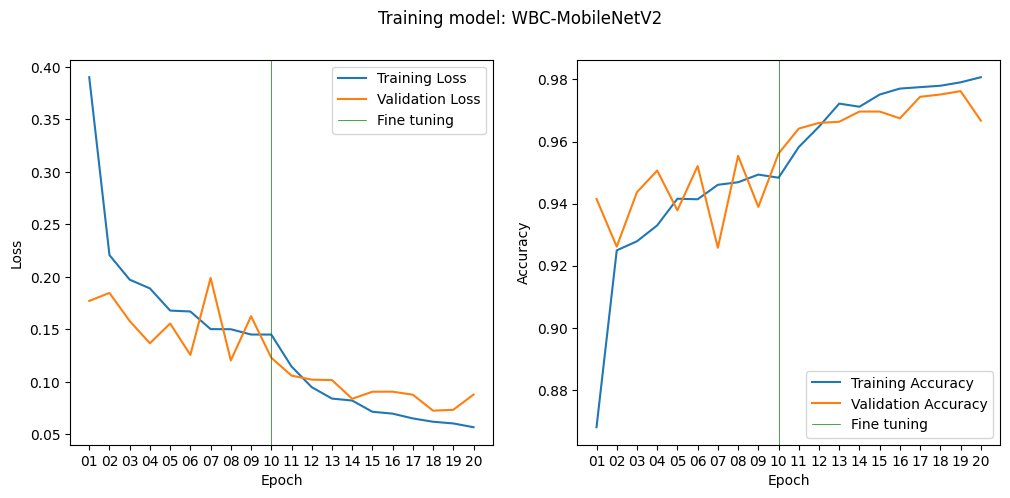

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f'Training model: {model.name}')
metrics.plot(y=cols[::2], ax=axs[0])
axs[0].set_xticks(range(len(metrics)), [f'{ep:02}' for ep in range(1, len(metrics)+1)])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].axvline(FT_EPOCHS-1, lw=0.5, c='g', label='Fine tuning')
axs[0].legend(loc='upper right')
metrics.plot(y=cols[1::2], ax=axs[1])
axs[1].set_xticks(range(len(metrics)), [f'{ep:02}' for ep in range(1, len(metrics)+1)])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].axvline(FT_EPOCHS-1, lw=0.5, c='g', label='Fine tuning')
axs[1].legend(loc='lower right')
plt.show()

>- Nous pouvons maintenant tenter de **prédire** les classes de globules blancs sur le jeu de données de tests,
>- afficher le **rapport de classification**,
>- afficher le **matrix de confusion**
>- et le **heatmap** de la matrice de confusion

In [13]:
from sklearn.metrics import classification_report
# model predictions
preds = model.predict(test_ds)

# Create dataframe from predictions
res = pd.DataFrame(preds, columns=cats, index=X_test.index)
res['prediction'] = res.idxmax(axis=1)
cm = pd.crosstab(df.loc[X_test.index, 'group'], res['prediction'], rownames=['Real'], colnames=['Pred'])

# Display results
display(res.round(6))
display(cm)
print(classification_report(df.loc[X_test.index, 'group'], res['prediction']))

107/107 [==============================] - 69s 633ms/step


,BASOPHIL,NEUTROPHIL,IG,MONOCYTE,EOSINOPHIL,ERYTHROBLAST,LYMPHOCYTE,PLATELET,prediction
8689,0.865366,0.000007,0.056259,0.066777,0.000005,0.000576,0.011008,0.000002,BASOPHIL
16076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,PLATELET
10398,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,EOSINOPHIL
9421,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,EOSINOPHIL
7008,0.000007,0.000298,0.999379,0.000310,0.000000,0.000005,0.000002,0.000000,IG
...,...,...,...,...,...,...,...,...,...
6835,0.000053,0.000126,0.999147,0.000661,0.000005,0.000006,0.000002,0.000000,IG
9530,0.000000,0.000015,0.000000,0.000000,0.999984,0.000000,0.000000,0.000000,EOSINOPHIL
1725,0.000005,0.932835,0.066457,0.000022,0.000680,0.000000,0.000000,0.000000,NEUTROPHIL
12916,0.000000,0.000002,0.000055,0.000000,0.000000,0.999929,0.000002,0.000012,ERYTHROBLAST


Pred,BASOPHIL,EOSINOPHIL,ERYTHROBLAST,IG,LYMPHOCYTE,MONOCYTE,NEUTROPHIL,PLATELET
Real,,,,,,,,
BASOPHIL,240,0,1,2,0,0,1,0
EOSINOPHIL,0,615,0,4,1,0,2,1
ERYTHROBLAST,0,0,303,3,3,0,1,0
IG,5,1,2,566,0,0,5,0
LYMPHOCYTE,0,0,4,3,235,0,0,1
MONOCYTE,1,2,0,34,4,241,2,0
NEUTROPHIL,0,2,1,28,0,0,635,0
PLATELET,0,0,1,1,0,0,0,468


              precision    recall  f1-score   support

    BASOPHIL       0.98      0.98      0.98       244
  EOSINOPHIL       0.99      0.99      0.99       623
ERYTHROBLAST       0.97      0.98      0.97       310
          IG       0.88      0.98      0.93       579
  LYMPHOCYTE       0.97      0.97      0.97       243
    MONOCYTE       1.00      0.85      0.92       284
  NEUTROPHIL       0.98      0.95      0.97       666
    PLATELET       1.00      1.00      1.00       470

    accuracy                           0.97      3419
   macro avg       0.97      0.96      0.97      3419
weighted avg       0.97      0.97      0.97      3419



The heatmap of the confusion matrix

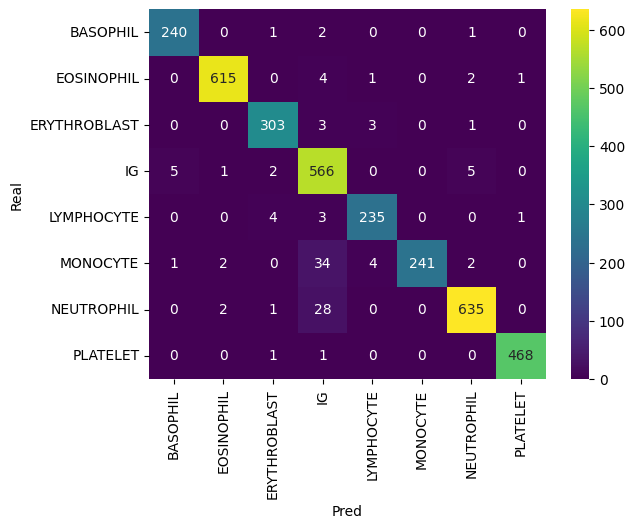

In [14]:
import seaborn as sns

ax = sns.heatmap(cm, cmap='viridis', annot=True, fmt='01')

## Visualisation des images de test avec les prédictions et les vraies labels

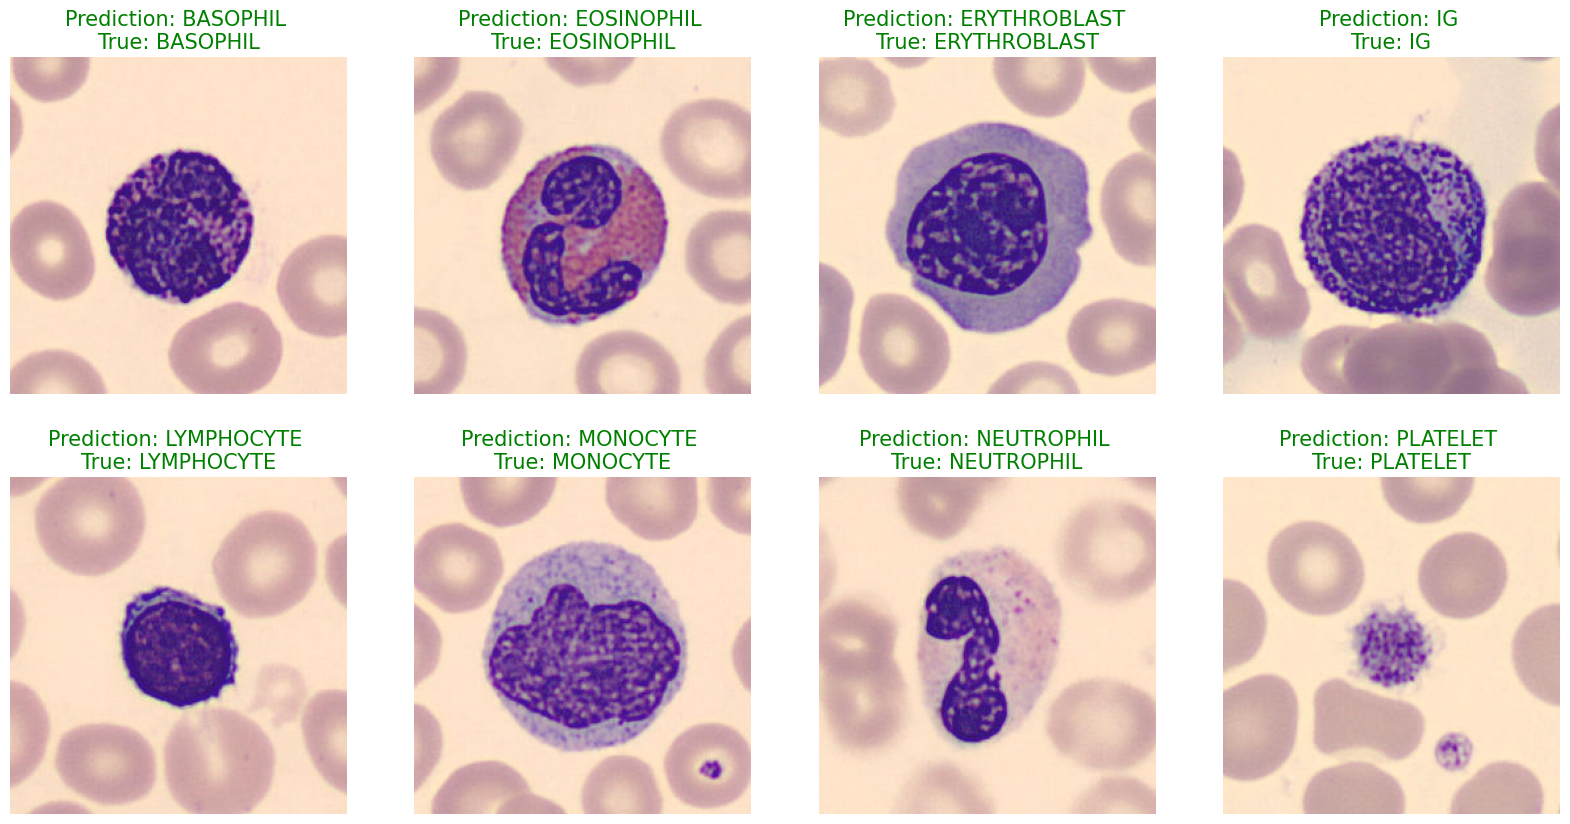

In [15]:
import matplotlib.pyplot as plt

idx = df.loc[df['dataset'] == 'test'].groupby('group').sample(n=1, random_state=2022).index
demo_ds = WBCDataSequence(X[idx], y[idx], image_size=INPUT_SHAPE[:2], batch_size=len(idx))
#print(df.loc[idx])
images, targets = demo_ds[0]  # the only batch of NUM_CLASSES images
images = np.uint8(images)    
plt.figure(figsize=(20, 10))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    if res.loc[idx].prediction.iloc[i] == df.loc[idx].group.iloc[i]:
        color = "g"
    else:
        color = "r"
    plt.title(f'Prediction: {res.loc[idx].prediction.iloc[i]} \nTrue: {df.loc[idx].group.iloc[i]}',
              fontsize = 15, c=color)
    plt.axis("off")

## Visualisation des images mal prédites

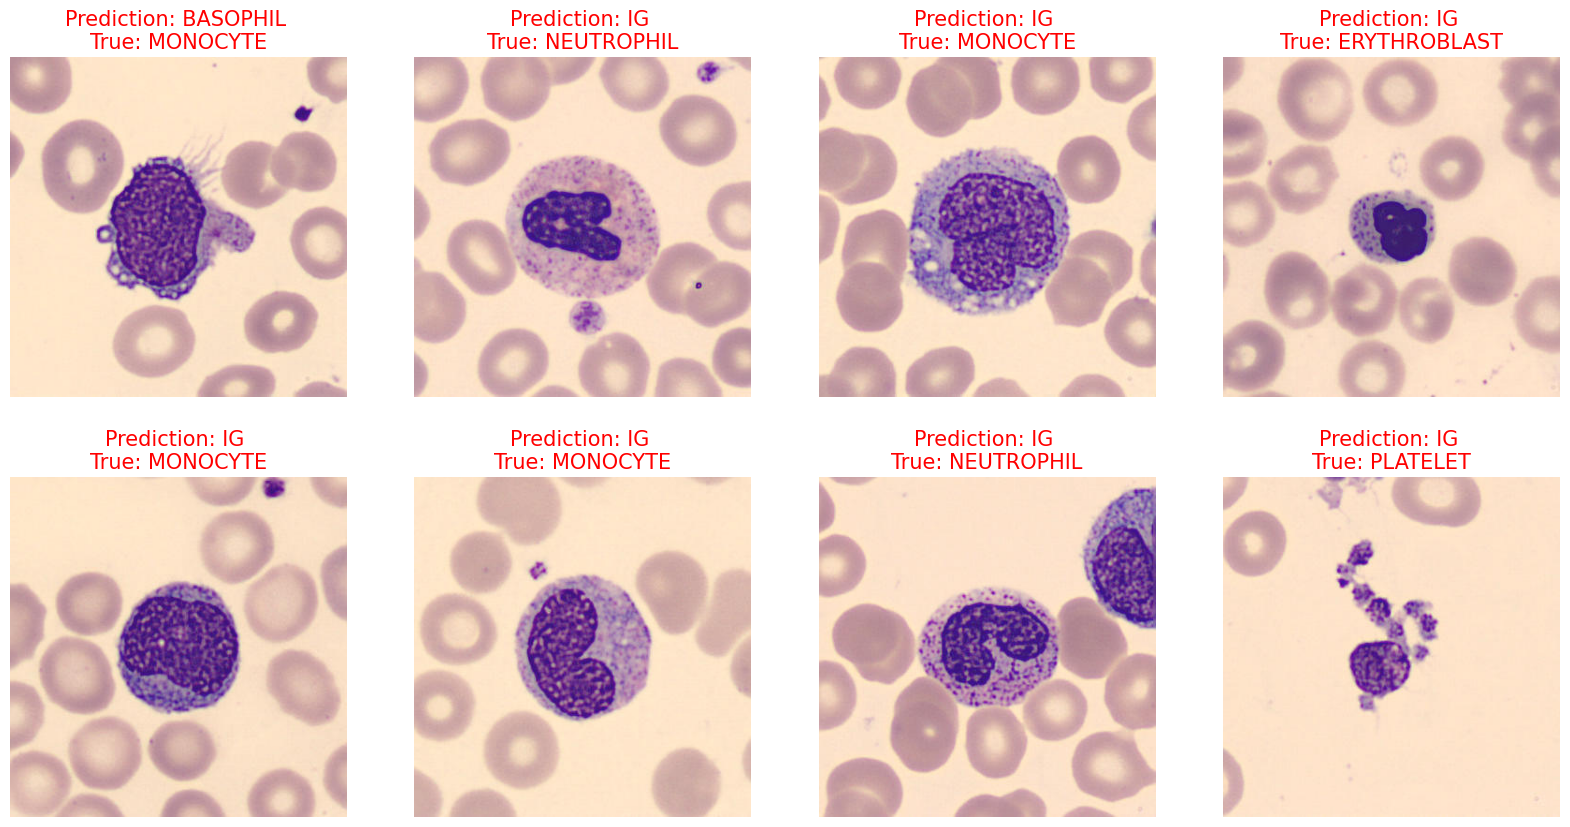

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#creating a dataframe containing the predictions and true labels for our test dataset
df_new=pd.DataFrame()
# predictions taken from dataframe res
df_new['pr']=res.prediction 
df_new['tr']=df.group # true label
# boolean mask of comparison of predictions and true labels
df_new['com']= df_new['pr']!=df_new['tr']
# dataframe for badly classified images
cl_bad=df_new.loc[df_new['com']==True] 
# indexes corresponding to badly classified images
bad_ind=cl_bad.index

# plotting badly classified images
plt.figure(figsize=(20, 10))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    image=mpimg.imread(df.path.iloc[bad_ind[i]])
    plt.imshow(image)
    # setting the font of the image title to green (correct prediction) or red (wrong prediction)
    if res.prediction.loc[bad_ind[i]] == df.group.loc[bad_ind[i]]:
        color = "g"
    else:
        color = "r"
    plt.title(f'Prediction: {res.prediction.loc[bad_ind[i]]} \nTrue: {df.group.loc[bad_ind[i]]}',
            fontsize = 15, c=color)
    plt.axis("off")